In [2]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id        repo_name                              repo_path
0    26235        concourse               github.com/pcfdev-forks/
1    28051        concourse                  github.com/concourse/
2    28030         sonobuoy               github.com/vmware-tanzu/
3    27913          clarity                     github.com/vmware/
4    26983        postfacto                    github.com/pivotal/
5    27169             gpdb                github.com/pivotal-gss/
6    25857             gpdb               github.com/greenplum-db/
7    25432  rabbitmq-server                   github.com/rabbitmq/
8    26600             gpdb  github.com/Pivotal-Field-Engineering/
9    27043            kpack                    github.com/pivotal/


In [4]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
repo_dict = {28031} #velero

In [5]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-24'
'2020-02-29'
'2019-03-01'


In [6]:
pr_all = pd.DataFrame()

for repo_id in repo_dict: 

    pr_query = s.sql.text(f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id
                            GROUP BY pull_requests.pull_request_id
                        ) response_times
                        ON pull_requests.pull_request_id = response_times.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) all_commit_counts
                        ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                        ) base_labels
                        ON base_labels.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) master_merged_counts 
                        ON base_labels.pull_request_id = master_merged_counts.pull_request_id                    
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id}
                        AND pr_created_at >= {year_ago}
                        AND pr_created_at <= {end_date}
                    ORDER BY
                       merged_count DESC
        """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
        
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {repo_id};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
pr_all.head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count
0,28031,298126943,velero,CONTRIBUTOR,vmware-tanzu,closed,2019-07-16 17:15:36,2019-07-16 16:48:25,2019-07-16 17:15:36,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28031,296371548,velero,CONTRIBUTOR,vmware-tanzu,closed,NaT,2019-07-10 22:20:20,2019-07-11 09:05:15,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,28031,297366116,velero,NONE,vmware-tanzu,closed,NaT,2019-07-14 04:26:02,2019-07-14 04:29:35,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28031,314714642,velero,MEMBER,vmware-tanzu,closed,2019-09-09 14:22:01,2019-09-05 21:42:33,2019-09-09 14:22:01,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,28031,283397128,velero,NONE,vmware-tanzu,closed,NaT,2019-05-29 19:20:23,2019-05-29 19:54:46,2019.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Response time by Month in Pandas

In [7]:
pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
pr_all['yearmonth'] = pr_all['pr_created_at'].dt.strftime('%Y-%m')
pr_all['diff_days'] = pr_all['diff'] / datetime.timedelta(days=1)
year_month_list = pr_all.yearmonth.unique()
year_month_list.sort()
first_response_means = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).mean()[['repo_name', 'yearmonth', 'diff_days']]
first_response_means

,repo_name,yearmonth,diff_days
0,velero,2019-03,0.709318
1,velero,2019-04,1.265909
2,velero,2019-05,1.122046
3,velero,2019-06,0.984999
4,velero,2019-07,2.316982
5,velero,2019-08,2.572118
6,velero,2019-09,2.179744
7,velero,2019-10,6.967576
8,velero,2019-11,2.645934
9,velero,2019-12,3.813811


### Response time by Month in PSQL

In [15]:
response_time_sql = s.sql.text(f"""
    SELECT 
        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
        (EXTRACT(epoch FROM avg(time_to_first_response))/86400) as mean_num_days_to_first_response
    FROM (
        SELECT 
            pull_requests.pull_request_id,
            MIN(message.msg_timestamp) - pr_created_at AS time_to_first_response,
            pr_created_at
        FROM pull_requests, repo, pull_request_message_ref, message
        WHERE 
            repo.repo_id = 28031
            AND repo.repo_id = pull_requests.repo_id
            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
            AND pull_request_message_ref.msg_id = message.msg_id
            AND pr_created_at >= {year_ago}
            AND pr_created_at <= {end_date}
            GROUP BY pull_requests.pull_request_id
    ) response_times
    GROUP BY CREATED_YEAR, CREATED_MONTH
""")
response_times = pd.read_sql(response_time_sql, con=engine)
response_times

,created_year,created_month,mean_num_days_to_first_response
0,2019.0,3.0,0.709318
1,2019.0,4.0,1.265909
2,2019.0,5.0,1.122046
3,2019.0,6.0,0.984999
4,2019.0,7.0,2.316982
5,2019.0,8.0,2.572118
6,2019.0,9.0,2.179744
7,2019.0,10.0,6.967576
8,2019.0,11.0,2.645934
9,2019.0,12.0,3.813811


### Difference between All and Closed PRs in Pandas

In [47]:
diff_all_closed = pd.DataFrame()

# Getting the counts of prs opened on any date
temp = pr_all.copy()
temp['date'] = temp['pr_created_at'].dt.date
temp = temp.groupby(['date'], as_index=False).count()[['date', 'pr_src_id']].rename(columns={'pr_src_id': 'all_pr_count'})
temp['date'] = pd.to_datetime(temp['date'])

# getting the cumsum of above counts of all prs
diff_all_closed['date'] = pd.date_range(start=year_ago, end=end_date)
diff_all_closed = pd.merge(diff_all_closed, temp, how='left', on='date')
diff_all_closed['all_pr_count'] = diff_all_closed['all_pr_count'].cumsum().fillna(method='ffill').fillna(0)

# Getting the counts of prs closed on any date
temp = pr_all.copy()
temp['date'] = temp['pr_closed_at'].dt.date
temp = temp.groupby(['date'], as_index=False).count()[['date', 'pr_src_id']].rename(columns={'pr_src_id': 'closed_pr_count'})
temp['date'] = pd.to_datetime(temp['date'])

# getting the cumsum of above counts of closed prs
diff_all_closed['date'] = pd.date_range(start=year_ago, end=end_date)
diff_all_closed = pd.merge(diff_all_closed, temp, how='left', on='date')
diff_all_closed['closed_pr_count'] = diff_all_closed['closed_pr_count'].cumsum().fillna(method='ffill').fillna(0)
diff_all_closed

,date,all_pr_count,closed_pr_count
0,2019-03-01,3.0,0.0
1,2019-03-02,3.0,0.0
2,2019-03-03,4.0,0.0
3,2019-03-04,5.0,1.0
4,2019-03-05,5.0,3.0
...,...,...,...
361,2020-02-25,501.0,490.0
362,2020-02-26,501.0,491.0
363,2020-02-27,503.0,493.0
364,2020-02-28,504.0,493.0


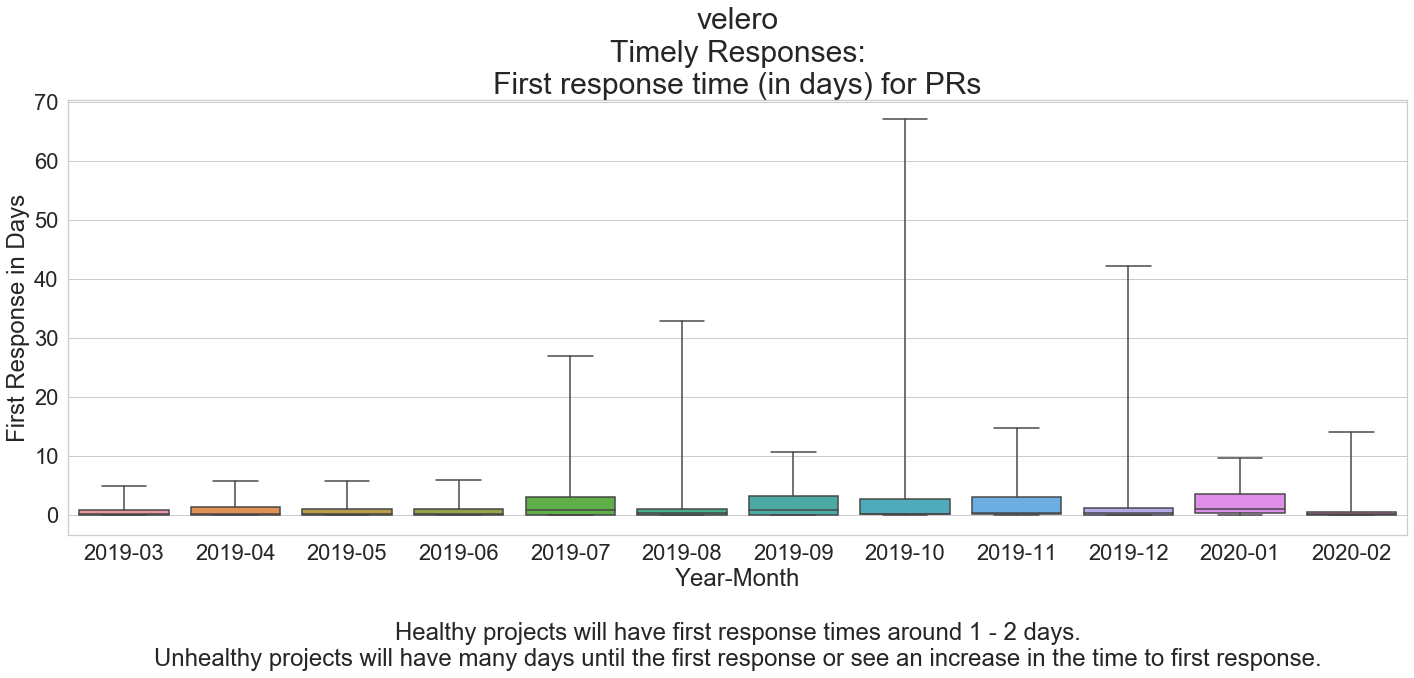

In [9]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
fig.set_size_inches(24, 8)

title = repo_name + "\nTimely Responses:\nFirst response time (in days) for PRs"

my_plot = sns.boxplot(x='yearmonth', y='diff_days', data=pr_all, ax=ax, order=year_month_list, showfliers = False, whis=100).set_title(title, fontsize=30)

risk_bar_labels = ax.set_ylabel('First Response in Days')
risk_bar_labels = ax.set_xlabel('Year-Month\n\nHealthy projects will have first response times around 1 - 2 days.\nUnhealthy projects will have many days until the first response or see an increase in the time to first response.')

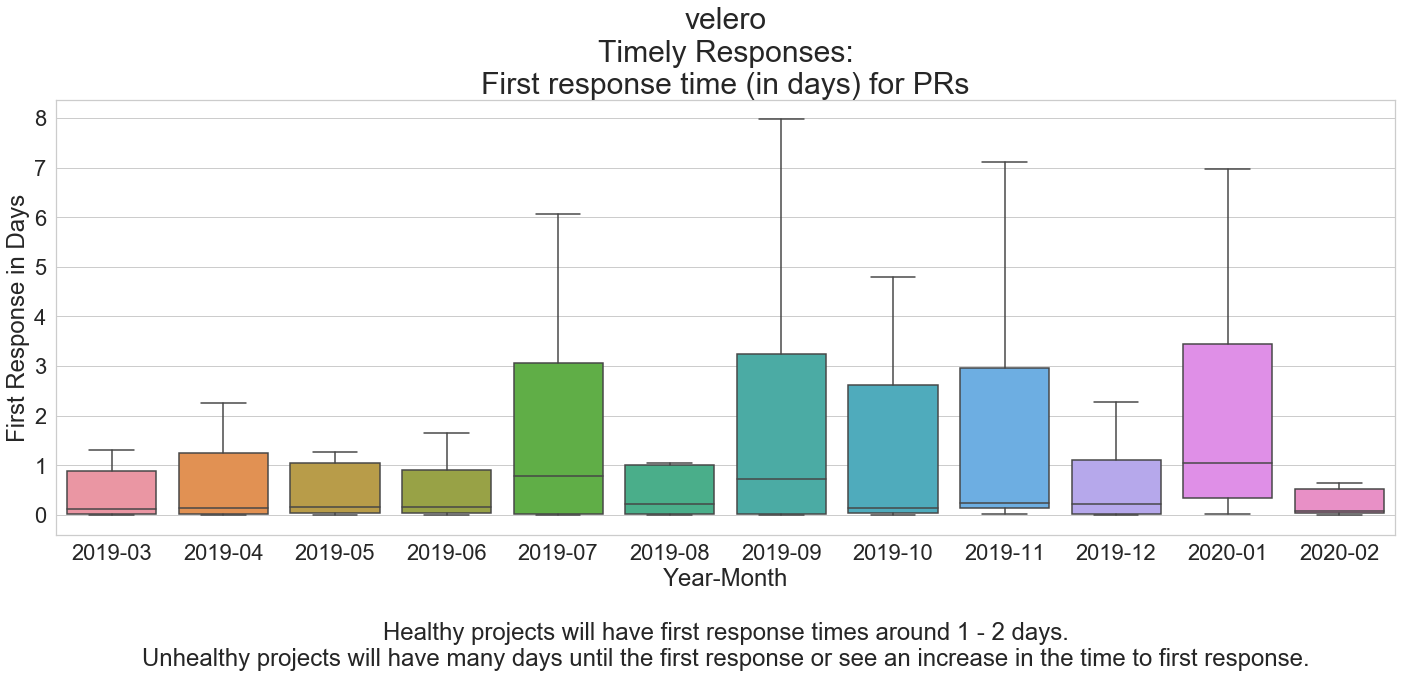

In [8]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
fig.set_size_inches(24, 8)

title = repo_name + "\nTimely Responses:\nFirst response time (in days) for PRs"

my_plot = sns.boxplot(x='yearmonth', y='diff_days', data=pr_all, ax=ax, order=year_month_list, showfliers = False, whis=1.5).set_title(title, fontsize=30)

risk_bar_labels = ax.set_ylabel('First Response in Days')
risk_bar_labels = ax.set_xlabel('Year-Month\n\nHealthy projects will have first response times around 1 - 2 days.\nUnhealthy projects will have many days until the first response or see an increase in the time to first response.')